### Problem statment

Let's suppose, thzt some object - victim has constant trajectiory. Next, there is an other object - hunter. The goal of hunter is to watch the victim. More specificly to be on a given target distance from victim with given a accuracy.
Hunter problem is that he knows restricted amount of information:

1. Is hunter close in on the victim: $\{0,1\}$

2. Is hunter on target distance with given accuracy: $\{0,1\}$

3. Dirrection of victim velocity $v_{v}$: $\frac{v_{v}}{||v_{v}||}$

4. Hunter velocity: $v_{h}$

In descrete time case hunter will have the following information:

1. Is hunter close in on the victim: $h\left(\left|\left|x_{h}^{-1}-x_{v}^{-1}\right|\right|-\left|\left|x_{h}^0-x_{v}^0\right|\right|\right)$

2. Is hunter on target distance $d_t$ with given accuracy $e_t$: $h \left(\left|\,\left|\left|x_{h}^0-x_{v}^0\right|\right|-d_t \,\right|- e_t\right)$

3. Dirrection of victim velocity: $\frac{x_{v}^0 - x_{v}^{-1}}{||x_{v}^0 - x_{v}^{-1}||}$

4. Hunter velocity: $x_{h}^0 - x_{h}^{-1}$

### Environment

### Constraied velocity change

Let's introduce innertion by constraining velocity change. If $a$ is maximal acceleration and $v_{-1}$ is velocity on the last iteration and  $v_n$ is current desired dirrection, then we can formulate problem of finding optimal shift as following:


$$v =  v_{n} c^*$$ 
$$c^* = \max c$$
$$s.t.:$$
$$||v_{-1}-v_{n}c||\le a$$
$$c\le1$$

Since ||v_{-1}-v_{n}c|| is continuous, optimal is achieved when $||v_{-1}-v_{n}c|| = a$ and $0 \le c \le 1$. 
Lets find c:

$$||v_{-1}-v_{n}c||^2 = a^2$$

$$||v_{n}||^2 c^2-2v_{-1}^Tv_{n}c+||v_{-1}||^2  - a^2 = 0$$

$$ c =  \frac{v_{-1}^Tv_{n}\pm \sqrt{(v_{-1}^Tv_{n})^2-||v_{n}||^2(||v_{-1}||^2  - a^2) }}{||v_{n}||^2}$$

Otherwise, if desired $c$ doesn't exist, we should stop as soon as possible:
$$v = v_{-1} k^*$$
$$k^* = \min k$$
$$||v_{-1}-k v_{-1}|| \le a$$
$$0 \le k \le 1$$

Analogously, optimal k:
$$ (1- k)^2 = \frac{a^2}{||v_{-1}||^2}$$
$$k^* = 1 - \frac{a}{||v_{-1}||}$$

Then, take into account bouds of k
    $$k^* = \max(0,1 - \frac{a}{||v_{-1}||})$$

In [16]:
from environment import HunterEnvironment
import numpy as np
import torch
import torch.nn as nn        

        
def eight_victim_policy(t):
    phi = (2*np.pi)/30*t*0.1/2
    r = 10*2

    x = r * np.sin(phi)
    y = r * np.sin(phi)*np.cos(phi)
    return np.array([x,y])

def circle_victim_policy(t):
    phi = (2*np.pi)/30*t*0.1
    r = 10+2*np.sin(phi*2)**2*0

    x = r * np.sin(phi)#+(t/20)
    y = r * np.cos(phi)#+(t/10)
    return np.array([x,y])

def ellipse_victim_policy(t):
    phi = (2*np.pi)/30*t*0.1
    r = 10+2*np.sin(phi*2)**2*0

    x = 2*r * np.sin(phi)#+(t/20)
    y = r * np.cos(phi)#+(t/10)
    return np.array([x,y])

def triangle_victim_policy(t):
    scale = 15
    speed = 0.01
    phi = (t*speed)%3
    a_vec = np.array([1/2,3**(1/2)/2])
    b_vec = np.array([1/2,-3**(1/2)/2])
    c_vec = np.array([-1, 0])
    out = a_vec*min(1,phi)+b_vec*max(min(1,phi-1),0)+c_vec*max(min(1,phi-2),0)
    return out*scale

### Hunter policy

Since hunter may moove only with speed constrained by some constant, we need to
constrain action space. Let's define max speed as $v_{max}$.
We may define our distribution via some function $G(x)$ from simple normal distribution $\mathcal{N}(x|\mu,diag(e^{2 s}))$.
Let's define function $g(x)$ so, that it was constrained in circle with radius $v_{max}$:
$$
G(x) = v_{max}\frac{x}{||x||_2}e^{-||x||_2^2} 
$$

$$\nabla_x\left[\textbf{f}(x)g(x)\right] = \frac{d\textbf{f}(x)}{dx}g(x)+\frac{dg(x)}{dx} \textbf{f}(x)^T $$

$$ \nabla_x G(x) =v_{max} \left( \frac{e^{-||x||_2^2}}{||x||_2} I + \nabla_x\left[\frac{e^{-||x||_2^2}}{||x||_2}\right]x^T\right) $$

$$ \nabla_x\left[\frac{e^{-||x||_2^2}}{||x||_2}\right] = \nabla_{||x||_2}\left[\frac{e^{-||x||_2^2}}{||x||_2}\right]\nabla_x||x||_2$$

$$\nabla_x||x||_2 = \frac{x}{||x||_2}$$
$$  \nabla_{||x||_2}\left[\frac{e^{-||x||_2^2}}{||x||_2}\right] = -\left[\frac{1}{||x||_2^2}+2\right]e^{-||x||_2^2}$$

$$ \nabla_x G(x) =v_{max}\frac{e^{-||x||_2^2}}{||x||_2} \left(I -\left[\frac{1}{||x||_2^2}+2\right] x x^T\right)  $$

$$\mathcal{J}_{G(x)}=-\left(v_{max} \frac{e^{-||x||_2^2}}{||x||_2}\right)^n \left(1-\left[\frac{1}{||x||_2^2}+2\right]||x||_2^2 \right) = 2\left(v_{max} \frac{e^{-||x||_2^2}}{||x||_2}\right)^n ||x||_2^2 $$

for 2 dimentions:
$$\mathcal{J}_{G(x)}=2 v_{max}^2 e^{-2||x||_2^2}$$

$$\ln(\mathcal{J}_{G(x)}^{-1})=2\left(||x||_2^2-\ln v_{max}\right)-\ln 2$$

So, PDF of distribution rv G(x) may be estimated as following:
$$\mathcal{N}(x|\mu,diag(e^{2s}))J_{G(x)}^{-1}$$

In [2]:
from policy import HunterPolicy
from train import train
%matplotlib inline

env = HunterEnvironment(ellipse_victim_policy, max_acceleration=0.5)
# policy = HunterPolicy(env,max_action=3)

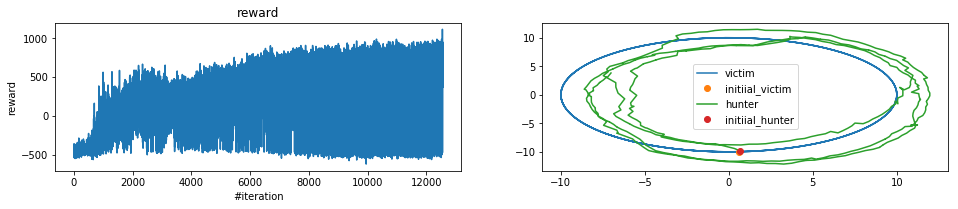

Episode 10	Last length:   999	Last reward: 749.00


KeyboardInterrupt: 

In [19]:
train(policy,env,100000,learning_rate=0.0001)

In [3]:
# torch.save(policy,'new_policy_speed_3.p')
policy = torch.load('acceleration_restricted_0.5_speed_3.p')

### Test Visualization

In [4]:
from visualization import model_hunter_learning

<IPython.core.display.Javascript object>


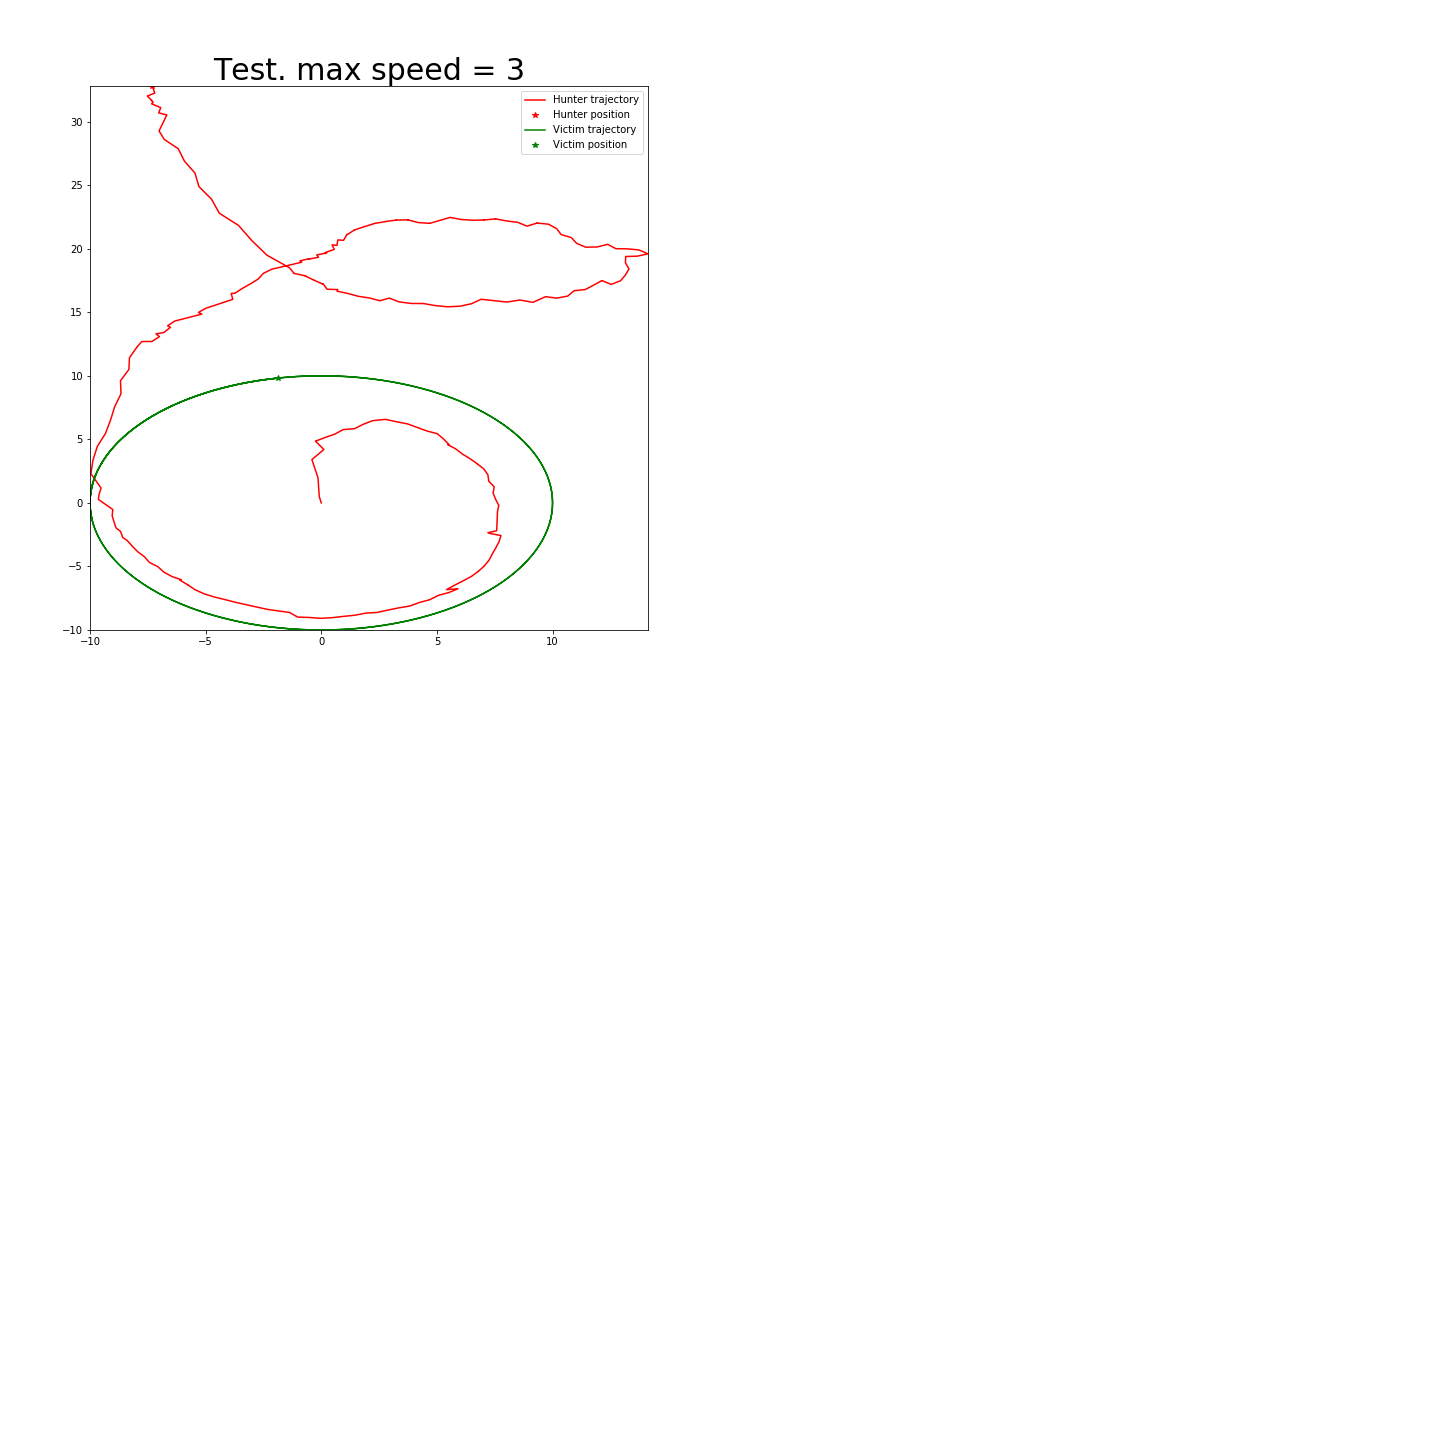

/Users/egornuzin/Yandex.Disk.localized/Files/Skoltech/Thesis/Hunter Learning/hunter_learning/environment.py:50: RuntimeWarning: invalid value encountered in sqrt
  c = max((b-np.sqrt(D))/a,(b+np.sqrt(D))/a)
/Users/egornuzin/Yandex.Disk.localized/Files/Skoltech/Thesis/Hunter Learning/hunter_learning/environment.py:50: RuntimeWarning: invalid value encountered in double_scalars
  c = max((b-np.sqrt(D))/a,(b+np.sqrt(D))/a)
/Users/egornuzin/Yandex.Disk.localized/Files/Skoltech/Thesis/Hunter Learning/hunter_learning/environment.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  c = max((b-np.sqrt(D))/a,(b+np.sqrt(D))/a)


KeyboardInterrupt: 

In [5]:
%matplotlib notebook
model_hunter_learning('Test. max speed = 3',policy,env,ellipse_victim_policy,hunter_start_position=[0,0])

<IPython.core.display.Javascript object>


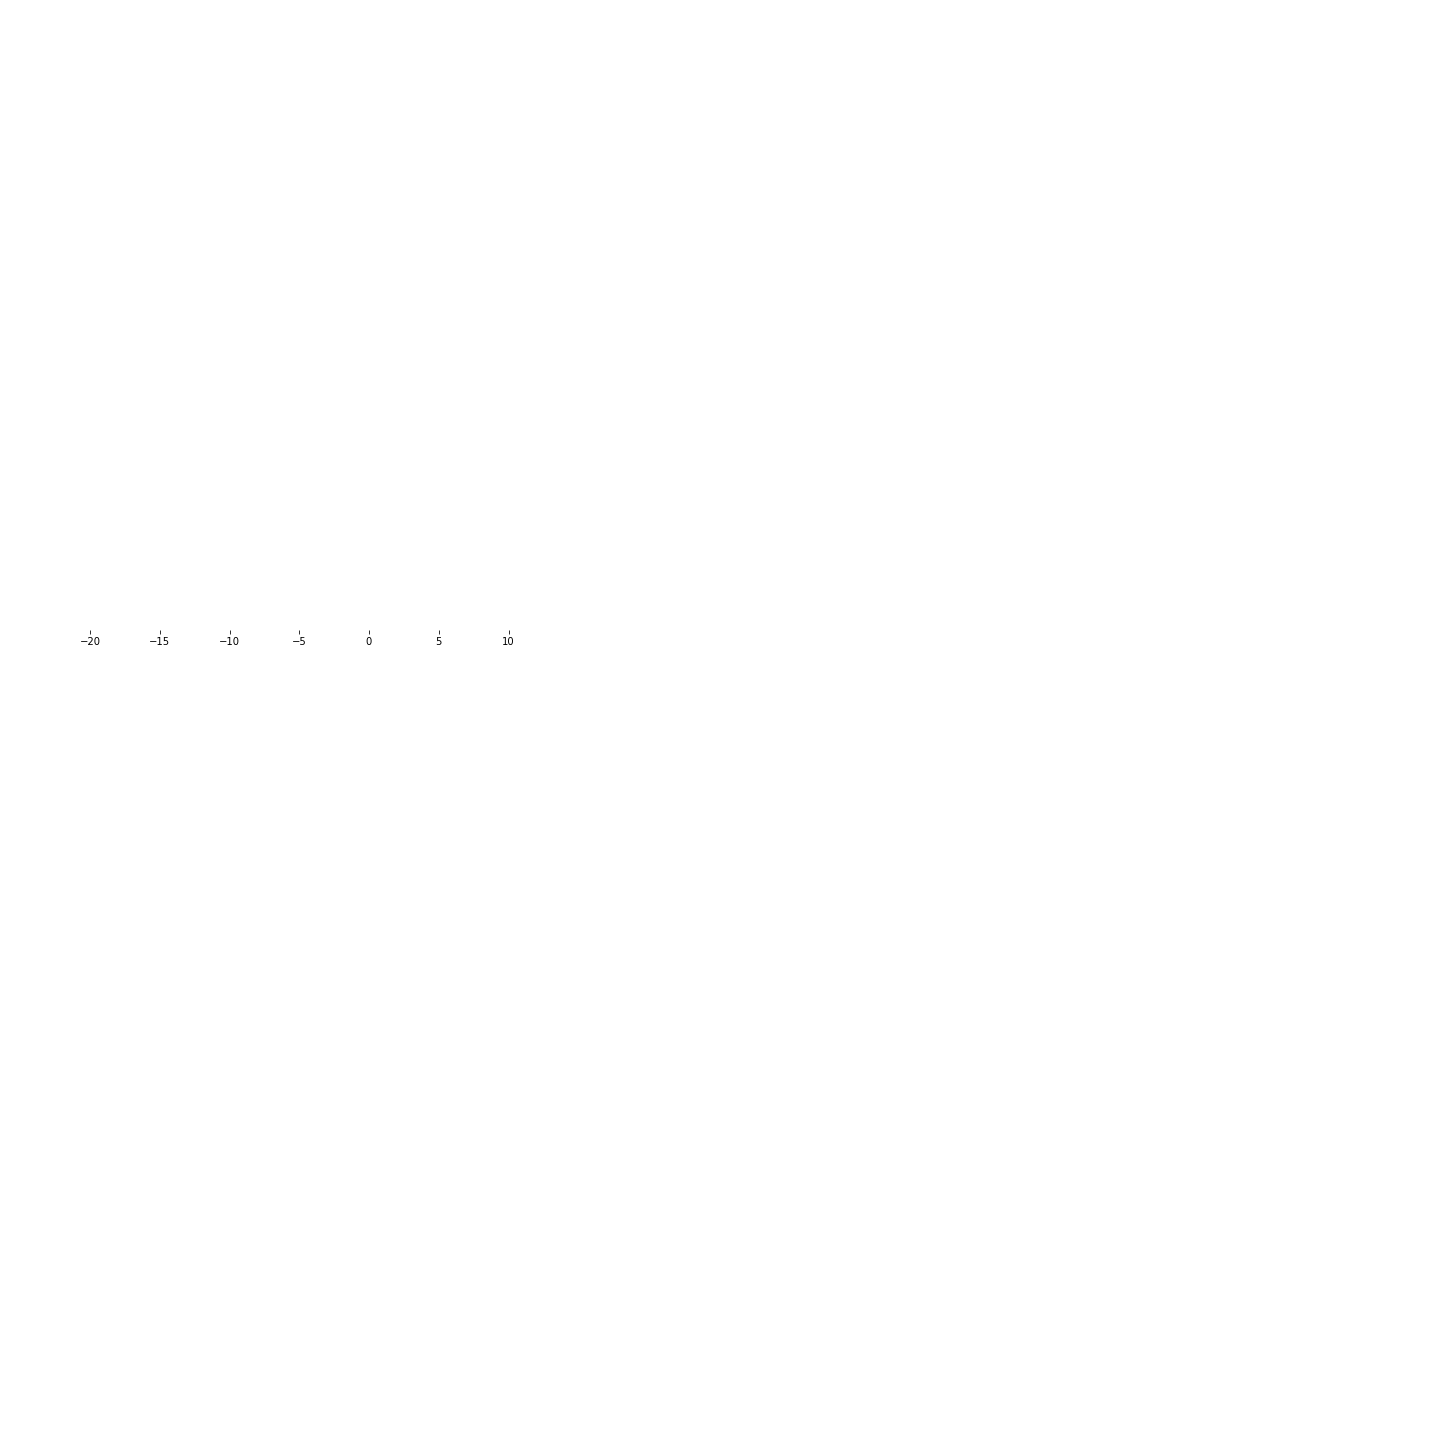

KeyboardInterrupt: 

In [25]:
# Ellipse

policy = torch.load('ellipse_policy_speed_3.p')
policy.max_action = 3
env = HunterEnvironment(ellipse_victim_policy)
model_hunter_learning('Test. max speed = 3',policy,env,ellipse_victim_policy,hunter_start_position=[0,0])

<IPython.core.display.Javascript object>


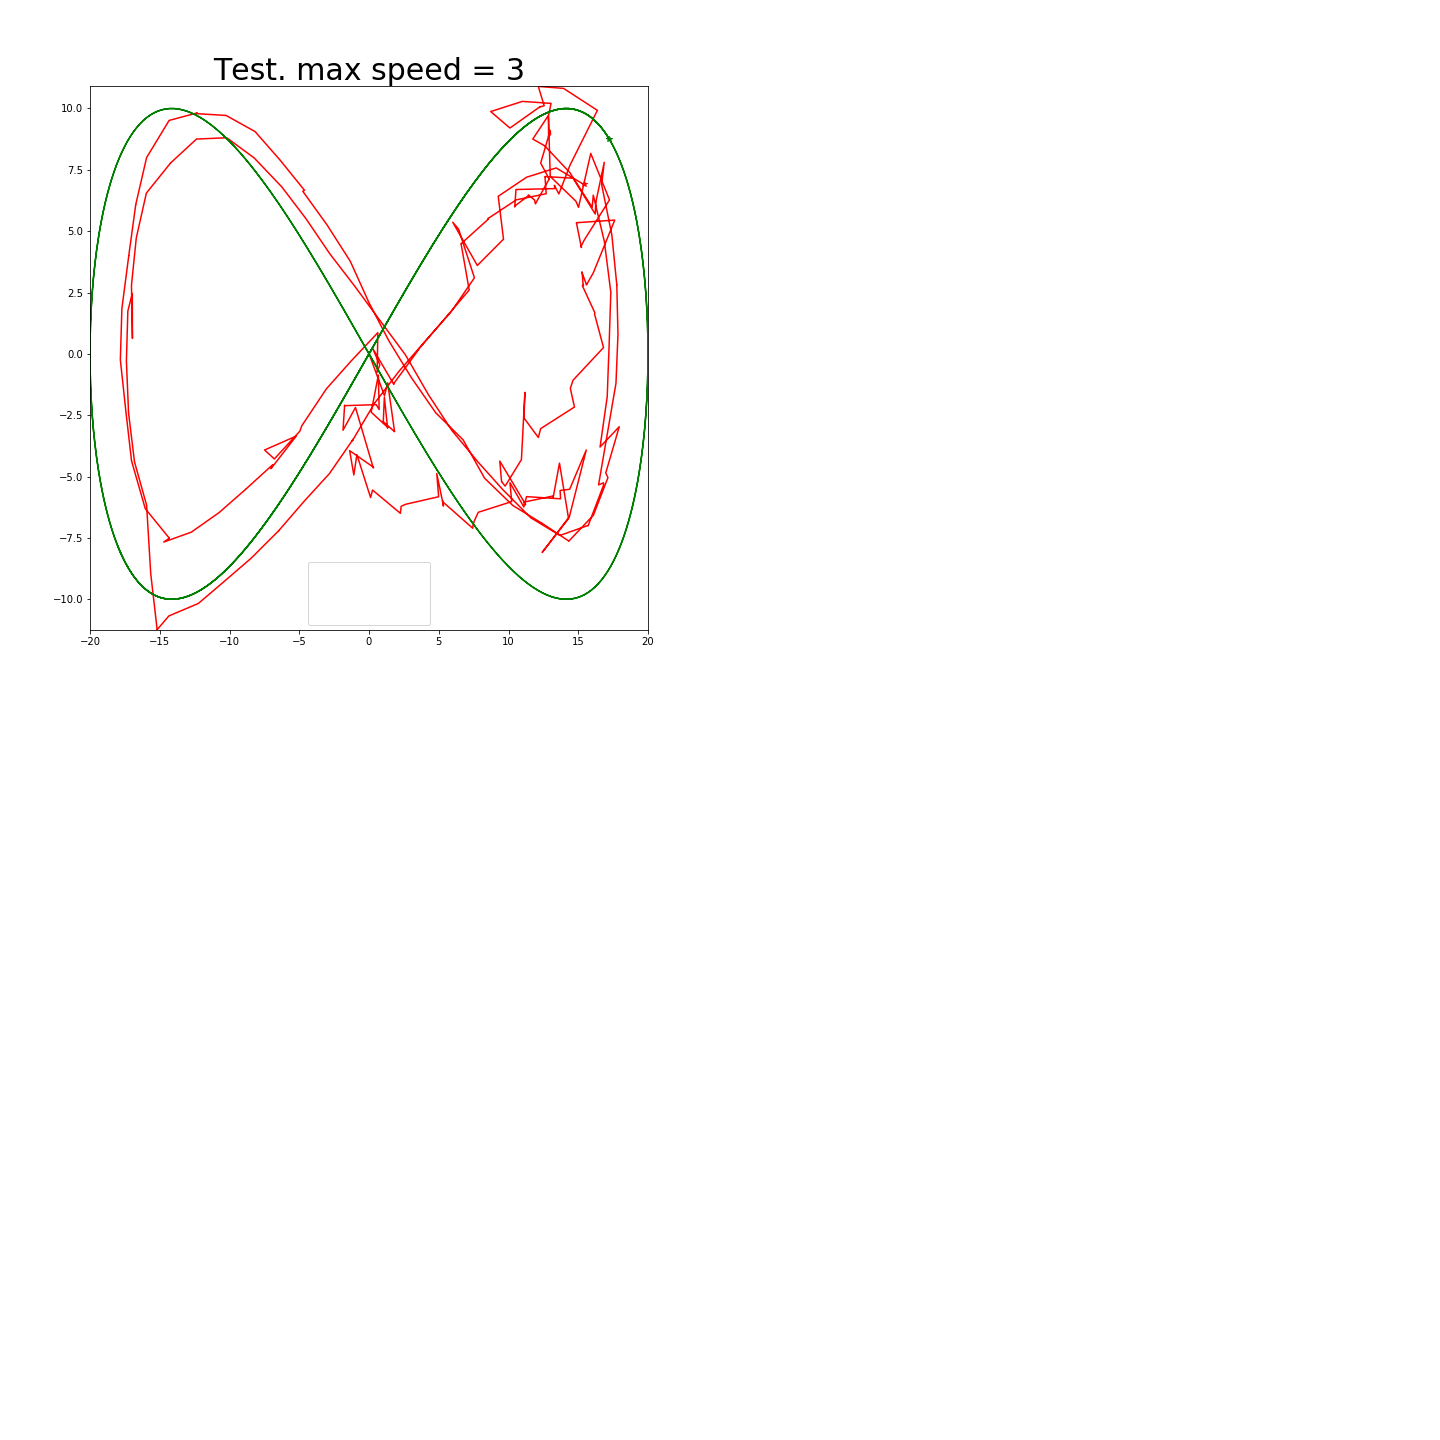

KeyboardInterrupt: 

In [26]:
# Eight

policy = torch.load('eight_policy_speed_3.p')
policy.max_action = 3
env = HunterEnvironment(eight_victim_policy)
model_hunter_learning('Test. max speed = 3',policy,env,eight_victim_policy,hunter_start_position=[0,0])

<IPython.core.display.Javascript object>


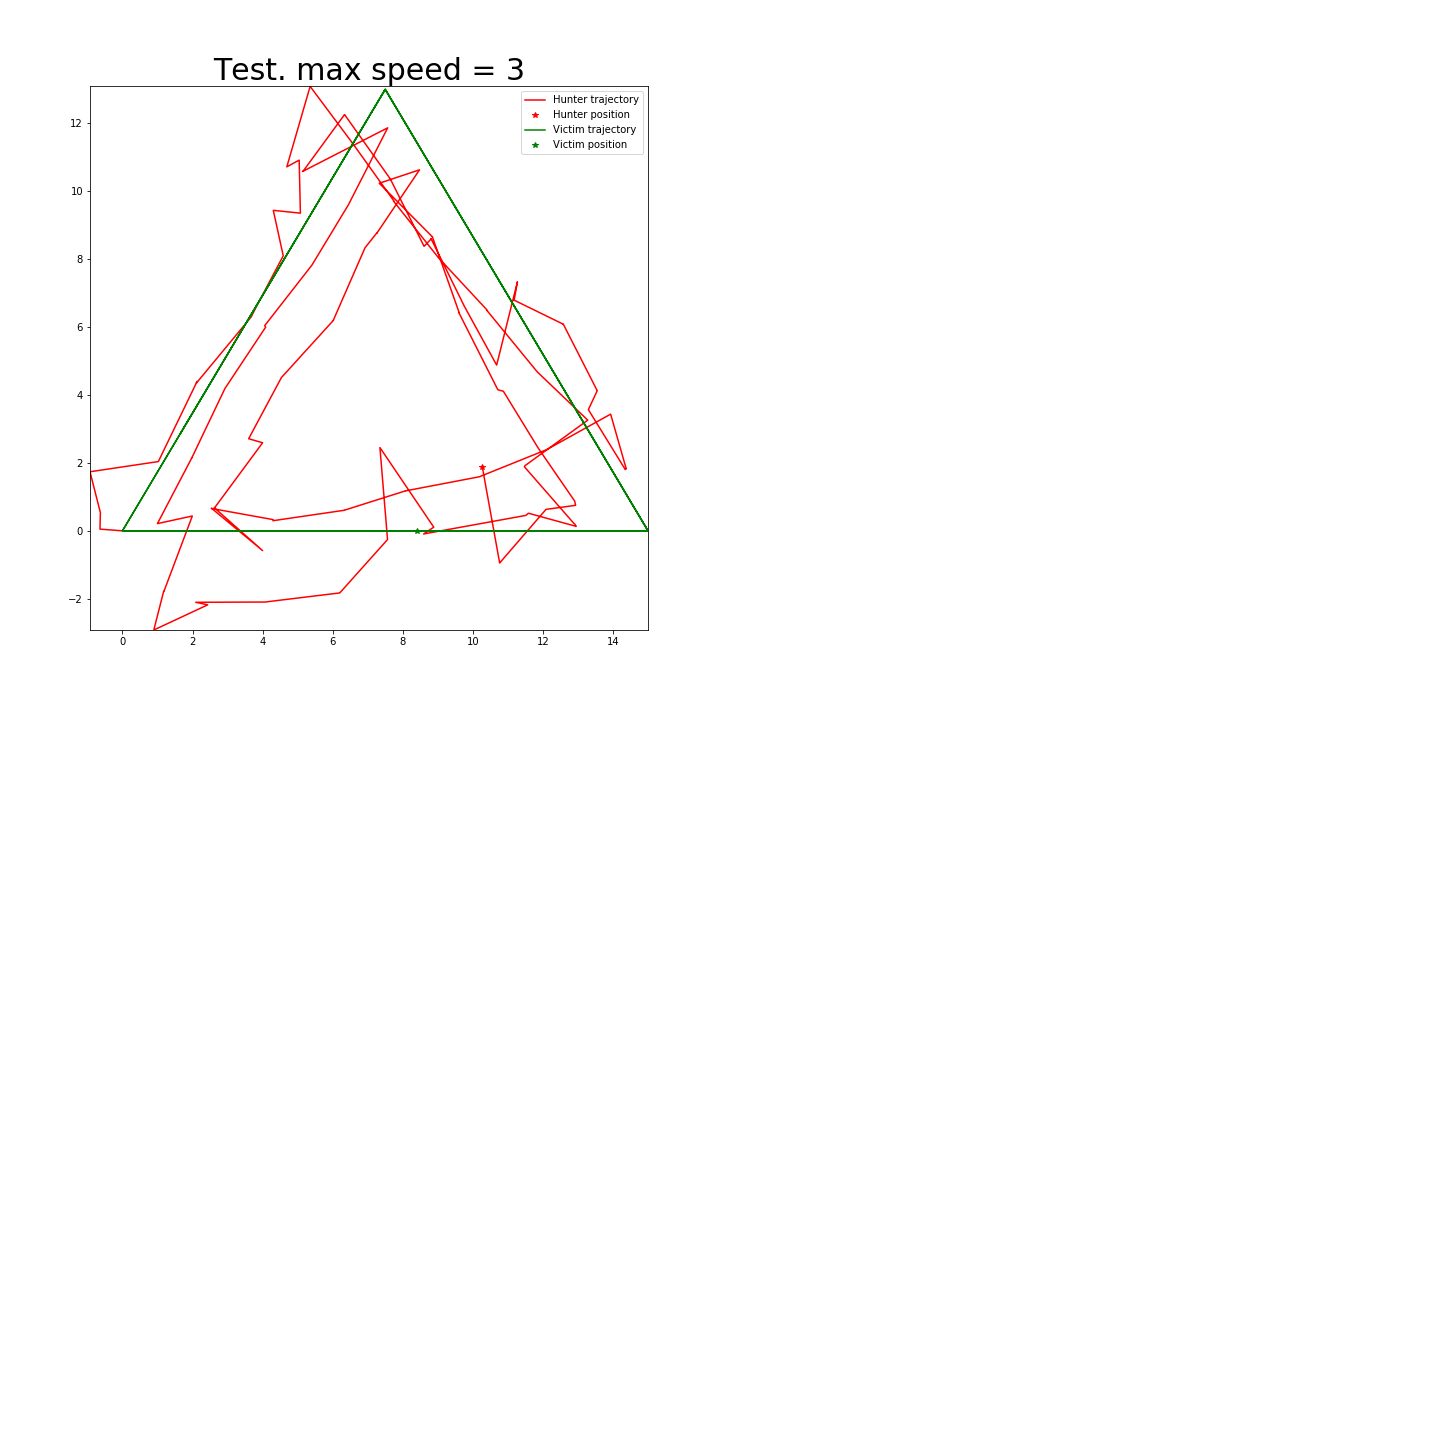

KeyboardInterrupt: 

In [27]:
# Triangular

policy = torch.load('triangle_policy_speed_3.p')
env = HunterEnvironment(triangle_victim_policy)
model_hunter_learning('Test. max speed = 3',policy,env,triangle_victim_policy,hunter_start_position=[0,0])

<IPython.core.display.Javascript object>


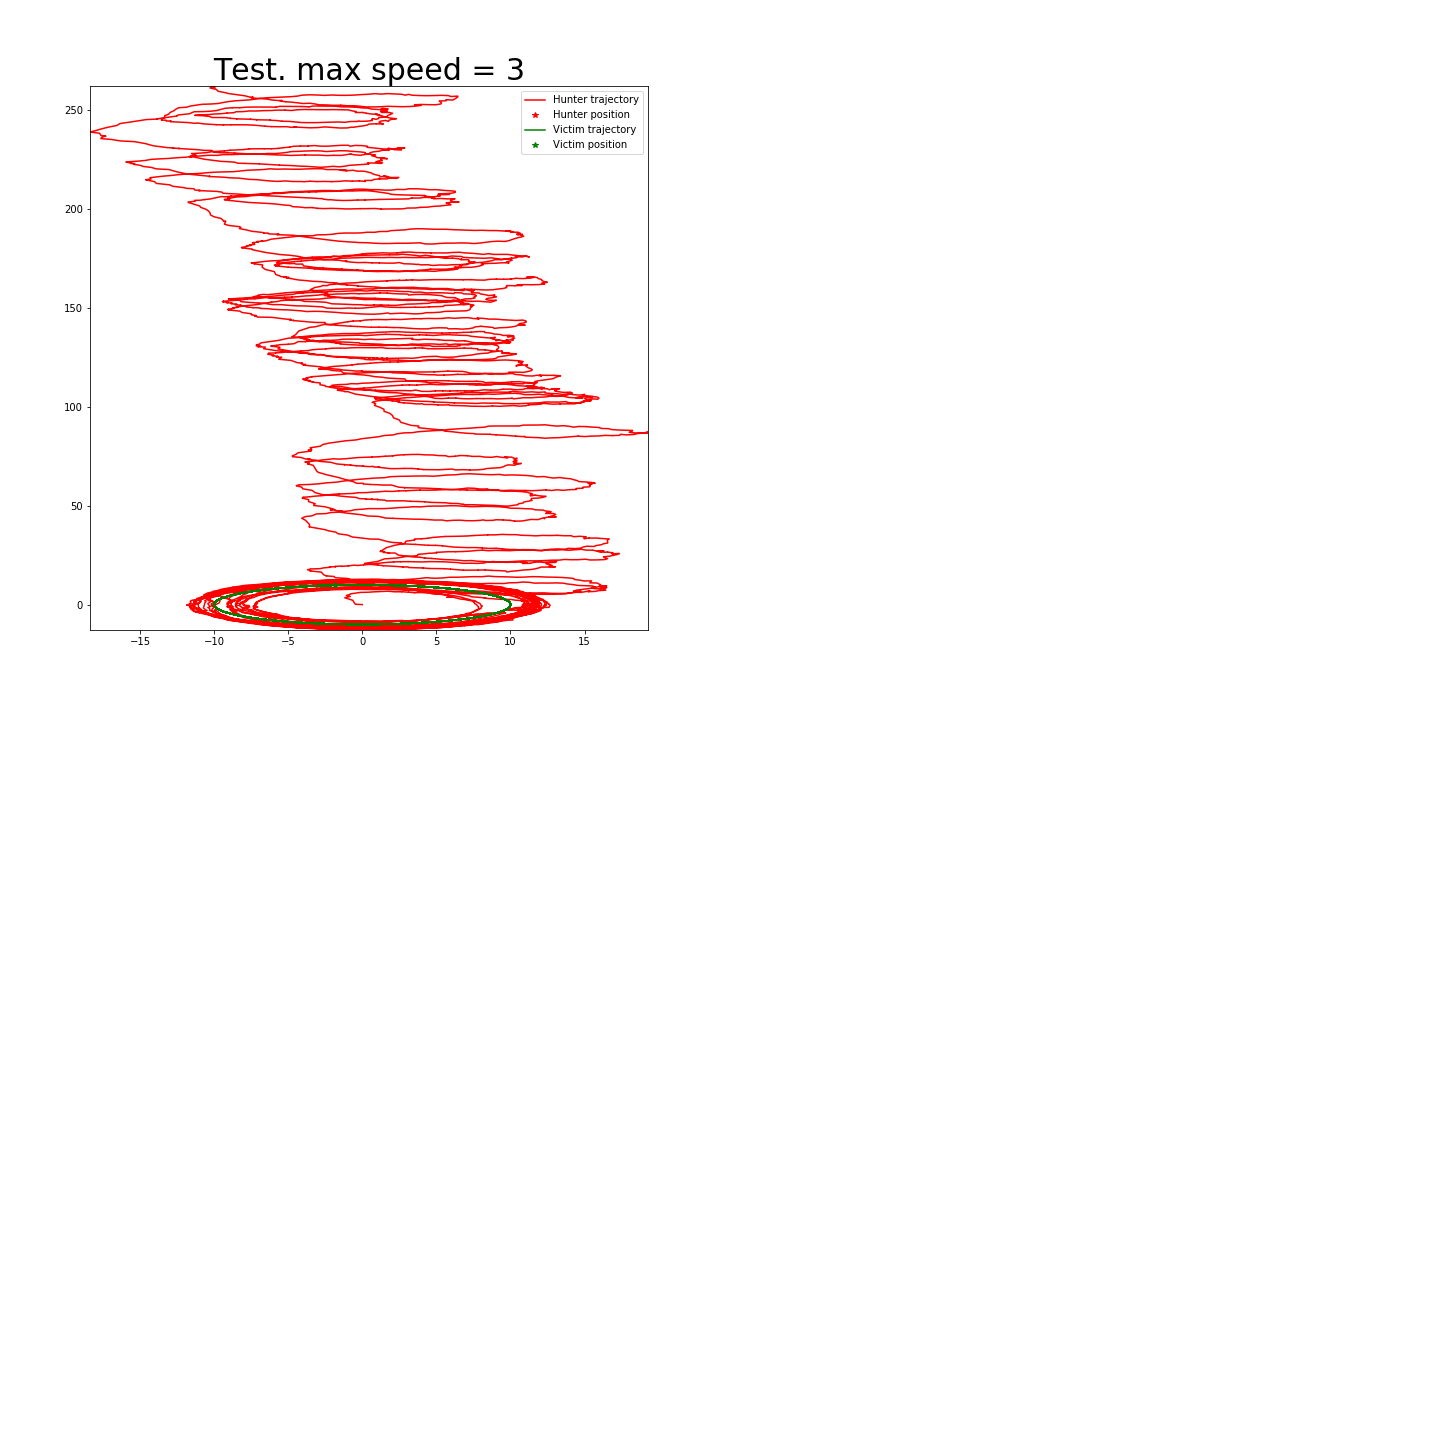

/Users/egornuzin/Yandex.Disk.localized/Files/Skoltech/Thesis/Hunter Learning/hunter_learning/environment.py:50: RuntimeWarning: invalid value encountered in sqrt
  c = max((b-np.sqrt(D))/a,(b+np.sqrt(D))/a)
/Users/egornuzin/Yandex.Disk.localized/Files/Skoltech/Thesis/Hunter Learning/hunter_learning/environment.py:50: RuntimeWarning: invalid value encountered in double_scalars
  c = max((b-np.sqrt(D))/a,(b+np.sqrt(D))/a)
/Users/egornuzin/Yandex.Disk.localized/Files/Skoltech/Thesis/Hunter Learning/hunter_learning/environment.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  c = max((b-np.sqrt(D))/a,(b+np.sqrt(D))/a)


In [ ]:
# Acceleration restricted

policy = torch.load('acceleration_restricted_0.5_speed_3.p')
env = HunterEnvironment(circle_victim_policy, max_acceleration=0.5)
model_hunter_learning('Test. max speed = 3',policy,env,circle_victim_policy,hunter_start_position=[0,0])